In [2]:
% First, make sure that the ESC toolbox functions are in the path
addpath readonly

In [3]:
% The following is the "helper function" used to initialize the EKF data structures

function ekfData = initEKF(v0,T0,SigmaX0,SigmaV,SigmaW,model)

  % Initial state description
  ir0   = 0;                           ekfData.irInd = 1;
  hk0   = 0;                           ekfData.hkInd = 2;
  SOC0  = SOCfromOCVtemp(v0,T0,model); ekfData.zkInd = 3;
  ekfData.xhat  = [ir0 hk0 SOC0]'; % initial state

  % Covariance values
  ekfData.SigmaX = SigmaX0;
  ekfData.SigmaV = SigmaV;
  ekfData.SigmaW = SigmaW;
  ekfData.Qbump = 5;
  
  % previous value of current
  ekfData.priorI = 0;
  ekfData.signIk = 0;
  
  % store model data structure too
  ekfData.model = model;
end

In [4]:
% The following is the "helper function" to update the EKF data structures every measurement interval.

function [zk,zkbnd,ekfData] = iterEKF(vk,ik,Tk,deltat,ekfData)
  model = ekfData.model;
  % Load the cell model parameters
  Q  = getParamESC('QParam',Tk,model);
  G  = getParamESC('GParam',Tk,model);
  M  = getParamESC('MParam',Tk,model);
  M0 = getParamESC('M0Param',Tk,model);
  RC = exp(-deltat./abs(getParamESC('RCParam',Tk,model)))';
  R  = getParamESC('RParam',Tk,model)';
  R0 = getParamESC('R0Param',Tk,model);
  eta = getParamESC('etaParam',Tk,model);
  if ik<0, ik=ik*eta; end;
  
  % Get data stored in ekfData structure
  I = ekfData.priorI;
  SigmaX = ekfData.SigmaX;
  SigmaV = ekfData.SigmaV;
  SigmaW = ekfData.SigmaW;
  xhat = ekfData.xhat;
  irInd = ekfData.irInd;
  hkInd = ekfData.hkInd;
  zkInd = ekfData.zkInd;
  if abs(ik)>Q/100, ekfData.signIk = sign(ik); end;
  signIk = ekfData.signIk;
  
  % EKF Step 0: Compute Ahat[k-1], Bhat[k-1]
  nx = length(xhat); Ahat = zeros(nx,nx); Bhat = zeros(nx,1);
  Ahat(zkInd,zkInd) = 1; Bhat(zkInd) = -deltat/(3600*Q);
  Ahat(irInd,irInd) = diag(RC); Bhat(irInd) = 1-RC(:);
  Ah  = exp(-abs(I*G*deltat/(3600*Q)));  % hysteresis factor
  Ahat(hkInd,hkInd) = Ah;
  B = [Bhat, 0*Bhat];
  Bhat(hkInd) = -abs(G*deltat/(3600*Q))*Ah*(1+sign(I)*xhat(hkInd));
  B(hkInd,2) = Ah-1;
  
  % Step 1a: State estimate time update
  xhat = Ahat*xhat + B*[I; sign(I)]; 
  
  % Step 1b: Error covariance time update
  %          sigmaminus(k) = Ahat(k-1)*sigmaplus(k-1)*Ahat(k-1)' + ...
  %                          Bhat(k-1)*sigmawtilde*Bhat(k-1)'
  SigmaX = Ahat*SigmaX*Ahat' + Bhat*SigmaW*Bhat';
  
  % Step 1c: Output estimate
  yhat = OCVfromSOCtemp(xhat(zkInd),Tk,model) + M0*signIk + ...
         M*xhat(hkInd) - R*xhat(irInd) - R0*ik;
  
  % Step 2a: Estimator gain matrix
  Chat = zeros(1,nx);
  Chat(zkInd) = dOCVfromSOCtemp(xhat(zkInd),Tk,model);
  Chat(hkInd) = M;
  Chat(irInd) = -R;
  Dhat = 1;
  SigmaY = Chat*SigmaX*Chat' + Dhat*SigmaV*Dhat';
  L = SigmaX*Chat'/SigmaY;
  
  % Step 2b: State estimate measurement update
  r = vk - yhat; % residual.  Use to check for sensor errors...
  if r^2 > 100*SigmaY, L(:)=0.0; end 
  xhat = xhat + L*r;
  xhat(hkInd) = min(1,max(-1,xhat(hkInd))); % Help maintain robustness
  xhat(zkInd) = min(1.05,max(-0.05,xhat(zkInd)));
  
  % Step 2c: Error covariance measurement update
  SigmaX = SigmaX - L*SigmaY*L';
  %   % Q-bump code
  if r^2 > 4*SigmaY, % bad voltage estimate by 2 std. devs, bump Q 
    fprintf('Bumping SigmaX\n');
    SigmaX(zkInd,zkInd) = SigmaX(zkInd,zkInd)*ekfData.Qbump;
  end
  [~,S,V] = svd(SigmaX);
  HH = V*S*V';
  SigmaX = (SigmaX + SigmaX' + HH + HH')/4; % Help maintain robustness
  
  % Save data in ekfData structure for next time...
  ekfData.priorI = ik;
  ekfData.SigmaX = SigmaX;
  ekfData.xhat = xhat;
  zk = xhat(zkInd);
  zkbnd = 3*sqrt(SigmaX(zkInd,zkInd));
end

In [5]:
% The following code provides the tuning values for the process-noise, sensor-noise, 
%and initial SOC-estimation-error covariance matrices. You will tune the filter by changing the values in this function.

% Every time you make a change to these tuning variables, make sure that you type < shift >< enter > in this code, 
%and then also press < shift >< enter > in the "wrapper code", below, that executes the EKF algorithm.

% function [SigmaW, SigmaV, SigmaZ0] = tuneEKF
%
% SigmaW - covariance value for current-sensor process noise
% SigmaV - covariance value for voltage-sensor measurement noise
% SigmaZ0 - covariance value for error in initial SOC estimate

function [SigmaW, SigmaV, SigmaZ0] = tuneEKF

  % BEGIN MODIFYING CODE AFTER THIS
  SigmaW  = 0.002; % This is a sample value. You will need to change it.
  SigmaV  = 0.00075; % This is a sample value. You will need to change it.
  SigmaZ0 = 0.003; % This is a sample value. You will need to change it.
end  

Please be patient. This code will take a minute or so to execute.
  Completed 300 out of 1500 iterations...
  Completed 600 out of 1500 iterations...
  Completed 900 out of 1500 iterations...
  Completed 1200 out of 1500 iterations...
  Completed 1500 out of 1500 iterations...
RMS SOC estimation error = 0.100535%
Final value of SOC estimation error bounds = 0.195372%
Percent of time error outside bounds = 0%


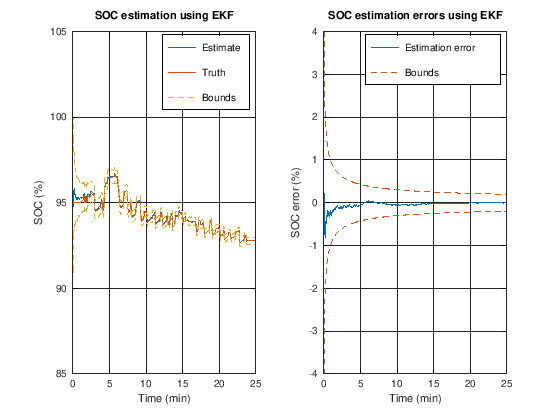

In [6]:
% The following "wrapper" code loads a lab-test data file, runs the EKF, and plots results.
%Make sure you type < shift >< enter> in the earlier "helper function" notebook cells before executing the "wrapper code".

% Load model file corresponding to a cell of this type
% Has the variables: current, SOC, time, voltage
load readonly/PAN_DATA.mat; % load data from Panasonic NMC cell, +25 degC
T = 25; % Test temperature

time    = DYNData.script1.time(:);   deltat = time(2)-time(1);
time    = time-time(1); % start time at 0
current = DYNData.script1.current(:); % discharge > 0; charge < 0.
voltage = DYNData.script1.voltage(:);
soc     = DYNData.script1.soc(:);

% Load cell-test data to be used for this batch experiment
% Contains variable "DYNData" of which the field "script1" is of 
% interest. This has sub-fields time, current, voltage, soc.
load readonly/PANmodel.mat; % load ESC model of Panasonic NMC cell

% Reserve storage for computed results, for plotting
sochat = zeros(size(soc));
socbound = zeros(size(soc));

% Get tuning values from user-modified function
[SigmaW, SigmaV, SigmaZ0] = tuneEKF;

SigmaX0 = diag([1e-6 1e-6 SigmaZ0]);
ekfData = initEKF(voltage(1),T,SigmaX0,SigmaV,SigmaW,model);
% This simulation tests the EKF when there is an inital SOC-estimation error
% The true initial SOC is 95%, but we will initialize the SOC estimate in the 
% filter to 90% and see how quickly and well the filter converges toward the
% correct SOC.
ekfData.xhat(ekfData.zkInd)=0.90; % 

% Now, enter loop for remainder of time, where we update the SPKF
% once per sample interval
fprintf('Please be patient. This code will take a minute or so to execute.\n')
for k = 1:length(voltage),
  vk = voltage(k); % "measure" voltage
  ik = current(k); % "measure" current
  Tk = T;          % "measure" temperature
  
  % Update SOC (and other model states)
  [sochat(k),socbound(k),ekfData] = iterEKF(vk,ik,Tk,deltat,ekfData);
  if mod(k,300)==0,
    fprintf('  Completed %d out of %d iterations...\n',k,length(voltage));
  end  
end
  
%%
subplot(1,2,1); plot(time/60,100*sochat,time/60,100*soc); hold on
plot([time/60; NaN; time/60],[100*(sochat+socbound); NaN; 100*(sochat-socbound)],'--');
title('SOC estimation using EKF'); grid on
xlabel('Time (min)'); ylabel('SOC (%)'); legend('Estimate','Truth','Bounds');

%%
J1 = sqrt(mean((100*(soc-sochat)).^2));
fprintf('RMS SOC estimation error = %g%%\n',J1);

%%
J2 = 100*socbound(end);
fprintf('Final value of SOC estimation error bounds = %g%%\n',J2);

%%
subplot(1,2,2); plot(time/60,100*(soc-sochat)); hold on
plot([time/60; NaN; time/60],[100*socbound; NaN; -100*socbound],'--');
title('SOC estimation errors using EKF');
xlabel('Time (min)'); ylabel('SOC error (%)'); ylim([-4 4]); 
legend('Estimation error','Bounds'); 
grid on

ind = find(abs(soc-sochat)>socbound);
fprintf('Percent of time error outside bounds = %g%%\n',length(ind)/length(soc)*100);
